In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import numpy as np

train_df = pd.read_pickle("../data/train_cens.pkl.gz")
train_df.head()

,name,parent,cens_slice,index
0,XC109605,acafly,"[[0.3086012466109237, 0.30568218743577036, 0.3...","(25, 75)"
0,XC109605,acafly,"[[0.37812375487169103, 0.3725999263434882, 0.3...","(157, 207)"
0,XC109605,acafly,"[[0.38193222855739883, 0.3810666924182529, 0.3...","(260, 310)"
0,XC109605,acafly,"[[0.3523993330368658, 0.3480284909351147, 0.34...","(324, 374)"
0,XC109605,acafly,"[[0.3179275282653602, 0.3194400852268083, 0.32...","(361, 411)"


In [2]:
import tensorflow as tf

def reshape_square(arr, k=25):
    """Domain specific. Transform 12x50 matrix into a square matrix that's 25x25."""
    x = np.zeros(k*k)
    a = arr.reshape(-1)
    x[:a.shape[0]] = a
    return x.reshape(k, k, 1)
    
X = np.stack(train_df.cens_slice.apply(reshape_square))

lb = LabelBinarizer()
lb.fit(train_df.parent)
y = lb.transform(train_df.parent)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [6]:
# https://github.com/tensorpack/tensorpack/blob/5845ead80e3d77c89e2f1e9d5e0691324a8354cc/examples/ResNet/cifar10-preact18-mixup.py#L101-L118

def _mixup(x_in, y_in):
    n = x_in.shape[0]
    # draw from uniform instead of beta(alpha, alpha, BATCH_SIZE)
    w = np.random.uniform(0.3, 0.7, size=n)
    x_weight = w.reshape(n, 1, 1, 1)
    index = np.random.permutation(n)

    x = x_in * x_weight + x_in[index] * (1-x_weight)
    y = y_in + y_in[index]
    return x, y

@tf.function(input_signature=[
    tf.TensorSpec(None, tf.float64), 
    tf.TensorSpec(None, tf.int32), 
])
def mixup(x_in, y_in):
    x, y = tf.numpy_function(_mixup, [x_in, y_in], [tf.float64, tf.int32])
    return tf.data.Dataset.from_tensor_slices((
        tf.reshape(x, [-1, 25,25,1]), 
        tf.reshape(y, [-1, 397])
    ))

def add_mixup(dataset, batch_size=1024):
    return (
        dataset
        .window(batch_size)
        .flat_map(lambda x, y: tf.data.Dataset.zip((x.batch(batch_size), y.batch(batch_size))))
        .map(mixup)
        .flat_map(lambda x: x)
        .batch(batch_size)
    )

add_mixup(test_dataset)

<BatchDataset shapes: ((None, 25, 25, 1), (None, 397)), types: (tf.float64, tf.int32)>

In [58]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Softmax, Flatten, Dense
from tensorflow_addons.metrics import F1Score

tf.config.list_physical_devices('GPU')
def get_compiled_model(input_shape=(25, 25, 1), output_shape=397):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(3, (25, 25), activation='relu', kernel_initializer='he_uniform', padding='valid'))
    model.add(Conv2D(output_shape, (1, 1), activation='relu', kernel_initializer='he_uniform', padding='valid'))
    model.add(Flatten())

#     model.add(Flatten())
#     model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
#     model.add(Dense(output_shape, activation='sigmoid'))
    
    model.compile(optimizer='adam',
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=['accuracy', F1Score(num_classes=output_shape)])
    return model

In [59]:
model = get_compiled_model()
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_88 (Conv2D)           (None, 25, 25, 32)        320       
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 25, 25, 32)        9248      
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 1, 1, 3)           60003     
_________________________________________________________________
conv2d_91 (Conv2D)           (None, 1, 1, 397)         1588      
_________________________________________________________________
flatten_10 (Flatten)         (None, 397)               0         
Total params: 71,159
Trainable params: 71,159
Non-trainable params: 0
_________________________________________________________________


In [60]:
history = model.fit(add_mixup(train_dataset), epochs=10, validation_data=test_dataset.batch(1024))

Epoch 1/10
432/432 [==============================] - 24s 53ms/step - loss: 0.6932 - accuracy: 0.0046 - f1_score: 9.2110e-06 - val_loss: 0.6931 - val_accuracy: 0.0022 - val_f1_score: 0.0000e+00 11s 45ms/step - loss: 0.6933 - accuracy: 0.0045  - 12s 45ms/step - loss: 0.6933 - accuracy: 0.004 - 14s 45ms/step - loss: 0.6933 - accuracy: 0.004 - 15s 45ms/step -  - 17s 45ms/step - loss: 0.6933 - 19s 45ms/step 
Epoch 2/10
432/432 [==============================] - 23s 53ms/step - loss: 0.6931 - accuracy: 0.0047 - f1_score: 0.0000e+00 - val_loss: 0.6931 - val_accuracy: 0.0022 - val_f1_score: 0.0000e+00
Epoch 3/10
432/432 [==============================] - 23s 53ms/step - loss: 0.6931 - accuracy: 0.0047 - f1_score: 0.0000e+00 - val_loss: 0.6931 - val_accuracy: 0.0022 - val_f1_score: 0.0000e+00
Epoch 4/10
432/432 [==============================] - 23s 54ms/step - loss: 0.6931 - accuracy: 0.0046 - f1_score: 0.0000e+00 - val_loss: 0.6931 - val_accuracy: 0.0022 - val_f1_score: 0.0000e+00
Epoch 5/10

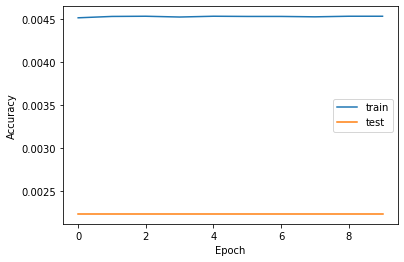

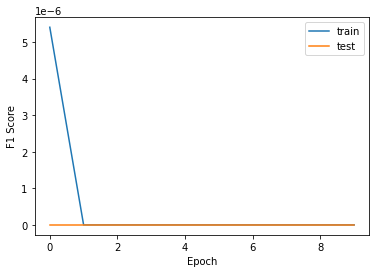

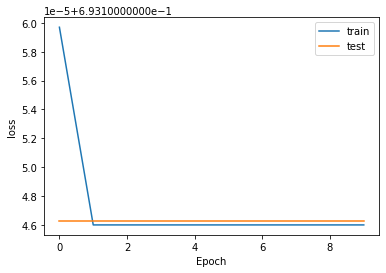

5914/5914 - 25s - loss: 0.6931 - accuracy: 0.0022 - f1_score: 0.0000e+00


[0.6931268572807312,
 0.002235244959592819,
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [61]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot([x.mean() for x in history.history['f1_score']], label='train')
plt.plot([x.mean() for x in history.history['val_f1_score']], label='test')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="test")
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

model.evaluate(X_test, y_test, verbose=2)